In [ ]:
#hide
from chitra.core import *

# Chitra

> Library for creating data input pipeline in Tensorflow

#hide
<!-- This file will become your README and also the index of your documentation. -->

## Install

`pip install chitra`

## How to use

<!-- Fill me in please! Don't forget code examples: -->
## Loading data for image classification

CLASSES ENCODED: {'cat': 0, 'dog': 1}


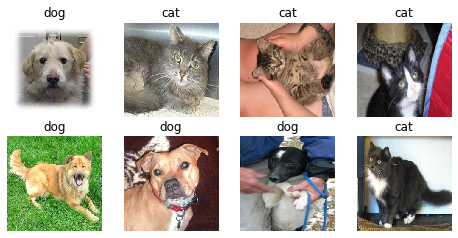

In [ ]:
import tensorflow as tf
import chitra
from chitra.dataloader import Clf, show_batch

path = '/Users/aniketmaurya/Pictures/data/train'

clf_dl = Clf()
data = clf_dl.from_folder(path, target_shape=(224, 224))

clf_dl.show_batch(8, figsize=(8,8))